# README

This notebook is designed to produce and compare chromatin contact heatmaps. It integrates output from the SpaceA Hi‑C pipeline and bulk Hi‑C experiments, focusing on brain and liver tissues at several developmental stages.

## Purpose

- calculate Pearson correlations between E‑values (eigenvector 1) inferred from SpaceA and bulk Hi‑C for each chromosome and tissue, to assess concordance.
- identify chromosomes with high agreement (chr2 in our case) and generate detailed contact heatmaps.
- visualise contact matrices alongside E1 profiles for SpaceA samples (`E11.5L2`, `E12.5L6`, `E13.5C1`, `E14.5F5`) and bulk Hi‑C (`E13.5`) in brain and liver.
- compare SpaceA and bulk Hi‑C contacts for the E13.5C1 sample.

## Contents

1. imports and parameter definitions (resolution, sample/tissue lists, paths).
2. correlation calculations across chromosomes.
3. helper functions for formatting genomic coordinates.
4. plotting routines:
     - contact maps with colour bars and E1 overlays for selected groups.
     - multi‑panel figures covering all SpaceA samples.
5. saving figures as PDF files into a specified directory.

## Requirements

- `cooler`, `cooltools`
- `numpy`, `pandas`, `seaborn`, `matplotlib`
- input `.cool` files and `.cis_eigs.csv` eigenvector files as described in the path variables.

本脚本绘制E11.5L2、E12.5L6、E13.5C1、E14.5F5四个样本Brain、Liver组织的互作热图，及E13.5时期bulk-HiC的互作热图，并与SpaceA的E13.5C1样本比较互作热图的差异。

In [1]:
import cooler
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cooltools.lib.numutils import adaptive_coarsegrain, interp_nan
mpl.rcParams['pdf.fonttype'] = 42


resolution = 1_000_000
tissue_list = ['Brain', 'Liver']
group_list = ['SpaceA', 'Bulk HiC']
samples_list = ['E11.5L2','E12.5L6','E13.5C1','E14.5F5']
spaceA_e1_dir = '/home/goubo/CRICK/CRICK/spaceA/higashi_v2/higashi/'
bulkhic_e1_dir = '/home/goubo/CRICK/CRICK/spaceA/bulkhicres/cooler_com/'
bulk_cool_dir = '/home/goubo/CRICK/CRICK/spaceA/bulkhicData/'
save_dir = '/home/xuyuetong/CRICK_Data_v3/Paper_Fig/Contact_Heatmap_v2/'

fruitpunch = sns.blend_palette(['white', 'red'], as_cmap=True)

In [ ]:
spacea_sample_id = 'E13.5C1'
bulkhic_sample_id = 'E13.5'

for tissue_id in tissue_list:
    spaceA_e1_path = '{0}{1}/{1}_fasthigashi_leiden_anno_man_{2}.cis_eigs.csv'.format(
        spaceA_e1_dir, spacea_sample_id, tissue_id)
    bulkhic_e1_path = '{0}{1}{2}.cis_eigs.csv'.format(
        bulkhic_e1_dir, bulkhic_sample_id, tissue_id.lower())
    spaceA_e1_data = pd.read_csv(spaceA_e1_path, index_col=0, header=0)
    bulkhic_e1_data = pd.read_csv(bulkhic_e1_path, index_col=0, header=0)
    for i in range(1, 20):
        chrom_id = 'chr' + str(i)
        spaceA_e1_chrom = spaceA_e1_data[spaceA_e1_data['chrom'] == chrom_id]
        bulkhic_e1_chrom = bulkhic_e1_data[bulkhic_e1_data['chrom'] == chrom_id]
        for j in range(1, 4):
            e_column = 'E' + str(j)
            e_values_spaceA = spaceA_e1_chrom[e_column].values
            e_values_bulkhic = bulkhic_e1_chrom[e_column].values
            mask = ~np.isnan(e_values_spaceA) & ~np.isnan(e_values_bulkhic)
            e_values_spaceA = e_values_spaceA[mask]
            e_values_bulkhic = e_values_bulkhic[mask]
            corr = np.corrcoef(e_values_spaceA, e_values_bulkhic)[0, 1]
            print(f'{tissue_id} {chrom_id} {e_column} correlation: {corr:.4f}')


Brain chr1 E1 correlation: 0.8890
Brain chr1 E2 correlation: -0.3242
Brain chr1 E3 correlation: -0.1664
Brain chr2 E1 correlation: 0.8660
Brain chr2 E2 correlation: 0.5863
Brain chr2 E3 correlation: 0.4519
Brain chr3 E1 correlation: -0.1091
Brain chr3 E2 correlation: 0.0497
Brain chr3 E3 correlation: 0.2208
Brain chr4 E1 correlation: 0.7225
Brain chr4 E2 correlation: 0.5216
Brain chr4 E3 correlation: -0.5248
Brain chr5 E1 correlation: 0.8801
Brain chr5 E2 correlation: 0.3105
Brain chr5 E3 correlation: -0.3868
Brain chr6 E1 correlation: 0.6949
Brain chr6 E2 correlation: 0.4311
Brain chr6 E3 correlation: -0.4940
Brain chr7 E1 correlation: 0.8823
Brain chr7 E2 correlation: 0.6492
Brain chr7 E3 correlation: 0.4724
Brain chr8 E1 correlation: 0.4425
Brain chr8 E2 correlation: -0.1070
Brain chr8 E3 correlation: 0.1105
Brain chr9 E1 correlation: 0.8376
Brain chr9 E2 correlation: 0.7794
Brain chr9 E3 correlation: 0.1423
Brain chr10 E1 correlation: 0.5642
Brain chr10 E2 correlation: -0.7729
Brai

因为我们希望使用BulkHiC的结果作为验证集，证明SpaceA结论的可靠。所以，需要BulkHiC的数据与SpaceA的数据尽量一致。本实验计算了BulkHiC的Brain、Liver与SpaceA E13.5C1样本Brain、Liver各染色体E values的pearson相关系数。结果显示，chr2在BulkHiC和E13.5C1样本Liver、Brain之间都满足较高的相关系数。后续，实验将绘制chr2的互作热图。

In [3]:
from matplotlib.ticker import EngFormatter

bp_formatter = EngFormatter('B')

def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45,labelsize=10)
    ax.tick_params(axis='y', labelsize=10)

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 42 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'E', 'H', 'L', 'M', 'S', 'a', 'c', 'colon', 'd', 'e', 'eight', 'f', 'five', 'h', 'hyphen', 'i', 'k', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'q', 'r', 's', 'seven', 'space', 't', 'three', 'two', 'u', 'v', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 24, 26, 27, 29, 36, 37, 38, 40, 43, 47, 48, 54, 68, 70, 71, 72, 73, 75, 76, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 3228]
INFO:fontTools.subset:Closed glyph list

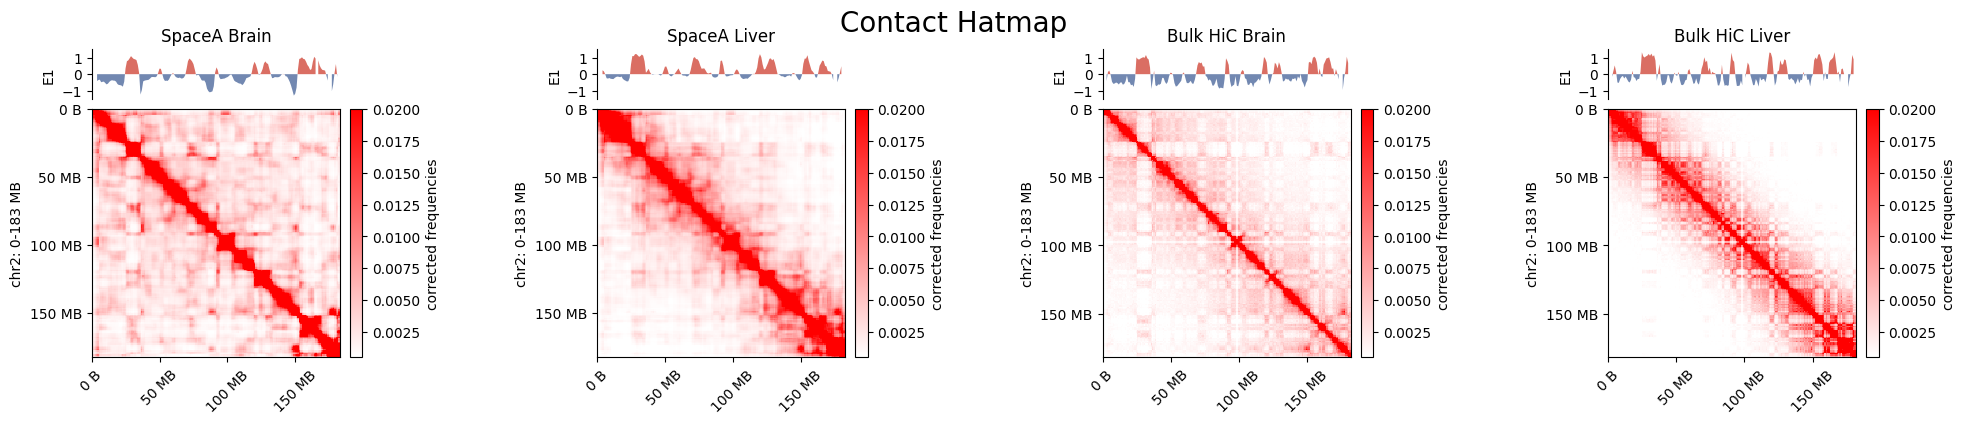

In [15]:
chrom_id = 'chr2'

input_paths = []
for group in group_list:
    if group == 'SpaceA':
        sample_id = 'E13.5C1'
        for tissue_id in tissue_list:
            cool_path = '{0}{1}/{1}_fasthigashi_leiden_anno_man_{2}.cool'.format(
                spaceA_e1_dir, sample_id, tissue_id)
            e1_path = '{0}{1}/{1}_fasthigashi_leiden_anno_man_{2}.cis_eigs.csv'.format(
                spaceA_e1_dir, sample_id, tissue_id) 
            input_paths.append((group, tissue_id, cool_path, e1_path))
    else:
        sample_id = 'E13.5'
        for tissue_id in tissue_list:
            cool_path = '{0}{1}{2}.allValidPairs_0.mcool::/resolutions/{3}'.format(
                bulk_cool_dir, sample_id, tissue_id.lower(), int(resolution))
            e1_path = '{0}{1}{2}.cis_eigs.csv'.format(
                bulkhic_e1_dir, sample_id, tissue_id.lower())
            input_paths.append((group, tissue_id, cool_path, e1_path))


f, axs_ctmap = plt.subplots(nrows=1, ncols=4, figsize=(25, 4))

for i, (group, tissue_id, cool_path, e1_path) in enumerate(input_paths):
    
    # import cool file
    clr = cooler.Cooler(cool_path)
    
    # # import e1 file
    e1_data = pd.read_csv(e1_path, index_col=0, header=0)
    e1_data['start_bin']=e1_data['start']/resolution
    e1_data['end_bin']=e1_data['end']/resolution   
    
    # get chroms
    start_bin,end_bin = clr.extent(chrom_id)-clr.offset(chrom_id)
    e1_chrom = e1_data[
        (e1_data['chrom']==chrom_id) & 
        (e1_data['start_bin']>=start_bin) & 
        (e1_data['end_bin']<=end_bin)]

    # ctmap
    cgi_tmp = interp_nan(clr.matrix(balance=True).fetch(chrom_id))
    

    vmin=0.0005
    vmax=0.020
    ax = axs_ctmap[i]
    im_tmp = ax.matshow(
        cgi_tmp, vmin=vmin, vmax=vmax, cmap=fruitpunch,
        extent=(0, clr.chromsizes[chrom_id], clr.chromsizes[chrom_id], 0))
    y_label = '{}: {}-{} MB'.format(chrom_id, start_bin, end_bin)
    ax.set_ylabel(y_label)
    format_ticks(ax)

    # color bar
    divider_tmp = make_axes_locatable(ax)
    ax_colorbar = divider_tmp.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im_tmp, cax=ax_colorbar, label='corrected frequencies')

    # E1
    ax_e1 = divider_tmp.append_axes("top", size="20%", pad=0.1)
    ax_e1.fill_between(e1_chrom.start_bin, e1_chrom['E1'], 0, 
                    where=e1_chrom['E1'] > 0, facecolor='#DA6E63', interpolate=True)
    ax_e1.fill_between(e1_chrom.start_bin, e1_chrom['E1'], 0, 
                    where=e1_chrom['E1'] < 0, facecolor='#7288B1', interpolate=True)
    ax_e1.set_ylabel('E1')
    ax_e1.set_title('{0} {1}'.format(group, tissue_id))
    ax_e1.set_xlim(xmin=start_bin,xmax=end_bin)
    ax_e1.set_ylim(-1.5, 1.5)
    ax_e1.set_xticks([])
    ax_e1.set_xticklabels([])
    ax_e1.spines['top'].set_visible(False)
    ax_e1.spines['right'].set_visible(False)
    ax_e1.spines['bottom'].set_visible(False) 
        
f.suptitle(f'Contact Hatmap', fontsize=20)
f.savefig('{0}Heatmap_Contact_BulkHiC_SpaceA.{1}.pdf'.format(save_dir, chrom_id))


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 41 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'B', 'C', 'E', 'F', 'H', 'L', 'M', 'a', 'c', 'colon', 'd', 'e', 'eight', 'f', 'five', 'four', 'h', 'hyphen', 'i', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'q', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'v', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 37, 38, 40, 41, 43, 47, 48, 68, 70, 71, 72, 73, 75, 76, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 3228]
INFO:fontTools.subset:Closed glyph list ove

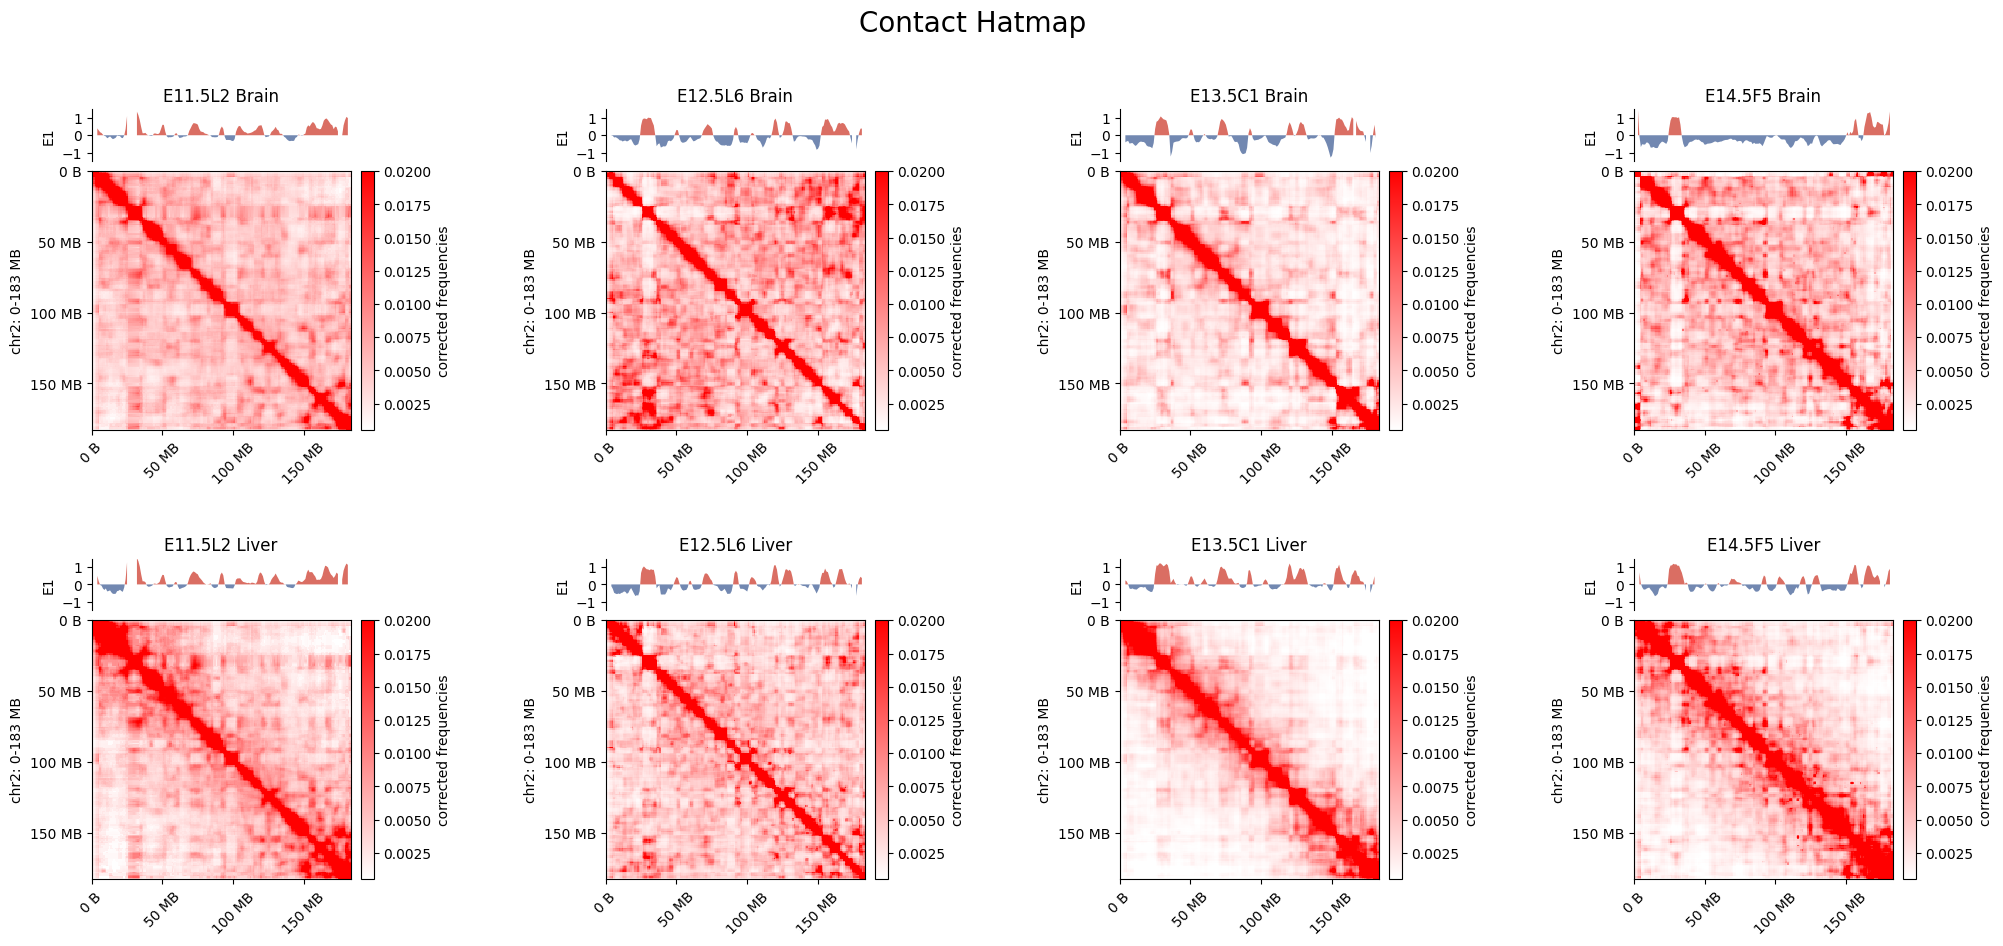

In [29]:
chrom_id = 'chr2'

input_paths = []
for sample_id in samples_list:
    for tissue_id in tissue_list:
        cool_path = '{0}{1}/{1}_fasthigashi_leiden_anno_man_{2}.cool'.format(
            spaceA_e1_dir, sample_id, tissue_id)
        e1_path = '{0}{1}/{1}_fasthigashi_leiden_anno_man_{2}.cis_eigs.csv'.format(
            spaceA_e1_dir, sample_id, tissue_id) 
        input_paths.append((sample_id, tissue_id, cool_path, e1_path))


f, axs_ctmap = plt.subplots(nrows=2, ncols=4, figsize=(25, 10), 
                            gridspec_kw={'hspace': 0.4, 'wspace': 0.3 })

for i, (sample_id, tissue_id, cool_path, e1_path) in enumerate(input_paths):
    
    # import cool file
    clr = cooler.Cooler(cool_path)
    
    # # import e1 file
    e1_data = pd.read_csv(e1_path, index_col=0, header=0)
    e1_data['start_bin']=e1_data['start']/resolution
    e1_data['end_bin']=e1_data['end']/resolution   
    
    # get chroms
    start_bin,end_bin = clr.extent(chrom_id)-clr.offset(chrom_id)
    e1_chrom = e1_data[
        (e1_data['chrom']==chrom_id) & 
        (e1_data['start_bin']>=start_bin) & 
        (e1_data['end_bin']<=end_bin)]

    # ctmap
    cgi_tmp = interp_nan(clr.matrix(balance=True).fetch(chrom_id))
    
    vmin=0.0005
    vmax=0.020
    ax = axs_ctmap[i%2, int(i/2)]
    im_tmp = ax.matshow(
        cgi_tmp, vmin=vmin, vmax=vmax, cmap=fruitpunch,
        extent=(0, clr.chromsizes[chrom_id], clr.chromsizes[chrom_id], 0))
    y_label = '{}: {}-{} MB'.format(chrom_id, start_bin, end_bin)
    ax.set_ylabel(y_label)
    format_ticks(ax)

    # color bar
    divider_tmp = make_axes_locatable(ax)
    ax_colorbar = divider_tmp.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im_tmp, cax=ax_colorbar, label='corrected frequencies')

    # E1
    ax_e1 = divider_tmp.append_axes("top", size="20%", pad=0.1)
    ax_e1.fill_between(e1_chrom.start_bin, e1_chrom['E1'], 0, 
                    where=e1_chrom['E1'] > 0, facecolor='#DA6E63', interpolate=True)
    ax_e1.fill_between(e1_chrom.start_bin, e1_chrom['E1'], 0, 
                    where=e1_chrom['E1'] < 0, facecolor='#7288B1', interpolate=True)
    ax_e1.set_ylabel('E1')
    ax_e1.set_title('{0} {1}'.format(sample_id, tissue_id))
    ax_e1.set_xlim(xmin=start_bin,xmax=end_bin)
    ax_e1.set_ylim(-1.5, 1.5)
    ax_e1.set_xticks([])
    ax_e1.set_xticklabels([])
    ax_e1.spines['top'].set_visible(False)
    ax_e1.spines['right'].set_visible(False)
    ax_e1.spines['bottom'].set_visible(False) 
        
f.suptitle(f'Contact Hatmap', fontsize=20)
f.savefig('{0}Heatmap_Contact_SpaceA_Allsample.{1}.pdf'.format(save_dir, chrom_id))